# Машинное обучение. ВМК МГУ

## Практическое задание 5: SVM


### Важно! О формате сдачи

* Практически все выделенные задания из ноутбука оцениваются по системе кросс-рецензирования. Задания, в котором надо реализовать свой код и послать в систему, выделены здесь и в pdf отдельно
* В этом задании есть <font color="red">новый тип задания -- ML-решение</font>
* При решении ноутбука используйте данный шаблон. Не нужно удалять текстовые ячейки c разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно можно
* Везде, где в формулровке задания есть какой-либо вопрос (или просьба вывода), необходимо прописать ответ в ячейку (код или markdown).
* Наличие кода решения обязательно. Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.

А также..

Если в ячейке написана фраза "Вывод"/"Ответ на вопрос" итд, то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано "Your code here", то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст)

Цель данного задания:

* Изучите работу модели SVM
* Поймете, как с её помощью можно строить нелинейные разделяющие поверхности
* Потренируетесь в подборе оптимальных параметров на обучающей выборке для достижения наилучшего качества на закрытой выборке (ML-решение)
* Узнаете про метод, который позволяет понижать число признаков и изучите его особенности на практике
* Научитесь корректировать выход модели SVM-классификатора, чтобы уметь получать вероятности

### *Примерное время выполнения всех ячеек ноутбука: 30 минут*

##Подготовка рабочей среды

Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий нажмите на кнопку Restart runtime, которая появится в следующей ячейке после завершения ее выполнения.

После перезапуска **(restart runtime)** устанавливать библиотеки еще раз не нужно, достаточно проверить, что установилась их новая версия.

На скачивание файла и установку понадобится не более 5 минут.

**Важно!** 
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то предлагаем вам завести виртуальное окружение и установить в нем библиотеки из файла requirements.txt по ссылке https://drive.google.com/file/d/1br9tHmdccGVzpk0svXNmHxVMh_OF2oZR/view?usp=sharing В таком случае виртуальное окружение достаточно настроить всего один раз.

In [1]:
# ! gdown 1br9tHmdccGVzpk0svXNmHxVMh_OF2oZR
# ! pip install -r /content/requirements.txt

**Нажмите на кнопку <font color='red'>Restart runtime</font>, которая появилась в выводе ячейки сверху после завершения ее выполнения.**

**После перезапуска (restart runtime) устанавливать библиотеки еще раз не нужно, достаточно проверить, что установилась их новая версия.**

In [2]:
import matplotlib
# assert(matplotlib.__version__ == '3.5.3')

Теперь можно приступать к выполнению задания! :)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from copy import copy

Если Вы дальтоник, то можете воспользоваться готовой colormap из matplotlib (или найти свою):
```
plt.style.use('tableau-colorblind10')
```

In [4]:
from matplotlib.colors import ListedColormap

from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.datasets import make_blobs, make_circles, make_moons

In [5]:
def make_moons_cls(size=1000, d=2):
    X, y = make_moons(n_samples=size, noise=0.15)
    if d > 2:
        X = np.concatenate((X, np.random.normal(size=(size, d-2))), axis=1)
    return X, y

def make_circles_cls():
    X, y = make_circles()
    
def generate_data_with_imb_classes(size1=100, size2=10):
    X = np.r_[(
        np.random.normal(loc=1.0, size=(size1, 2)),
        np.random.normal(loc=0.5, size=(size2, 2))
    )]
    
    y = np.ones(len(X))
    y[-size2:] = 0
    return X, y

In [6]:
def plot_separating_surface(X, y, cls, view_support=False, title=''):
    x_min = min(X[:, 0]) - 0.1
    x_max = max(X[:, 0]) + 0.1
    y_min = min(X[:, 1]) - 0.1
    y_max = max(X[:, 1]) + 0.1
    h = 0.005
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
    Z = cls.predict(np.c_[xx.ravel(), yy.ravel()])

    plt.figure(figsize=(10, 10))
    if title:
        plt.title(title)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', s=40, cmap=cm_bright)
    if view_support:
        plt.scatter(X[cls.support_, 0], X[cls.support_, 1], 
                    c=y[cls.support_], edgecolors='k', s=150, cmap=cm_bright)
    Z = Z.reshape(xx.shape)
    plt.xticks(())
    plt.yticks(())
    plt.contourf(xx, yy, Z, cmap=cm, alpha=.3)
    plt.show()

#### Загрузим данные для задания, их же вы можете найти в cv-gml

In [8]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1bp39_Jj0edo1lzxZ3DIoChsOVy5DVi1R?usp=sharing')

Retrieving folder list


Retrieving folder 1tv605hGxdQtd4zC787DbcRF0312gDeK_ imbalanced
Processing file 14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u X_imb_test.npz.npy
Processing file 1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc X_imb.npz.npy
Processing file 1uD87Xbh4MMBBn5fsScrknI54SINIqory y_imb_test.npz.npy
Processing file 1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf y_imb.npz.npy
Retrieving folder 1uoI6vZWwIII1jd2k5TtsZTJ3JOkK0G6O public
Processing file 1Win7ZtHLHEbDtX6x6O7vBJHwJviQxbp5 cX_test.npy
Processing file 1MowPnLFAMEjjcAjDA4skE4OUFdmaiSY6 cX_train.npy
Processing file 1VYA4N5wCQhwteQSZkDogFTha2xRv0FgW cy_train.npy
Processing file 1-p9irR7BtJAEq3EhrxVpphc8evrg0tIQ svm_solution.py
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=14zd2xHDChSHtMWQ_TUzM8td7s8gzCO2u
To: /home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/X_imb_test.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 10.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qed066d3gUsUOZiUZu6aCrIH9f0yWKSc
To: /home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/X_imb.npz.npy
100%|██████████| 2.05k/2.05k [00:00<00:00, 7.98MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uD87Xbh4MMBBn5fsScrknI54SINIqory
To: /home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/y_imb_test.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 1.76MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RR2VU_6WJMLo88k8C1VzBwb2Ibnz1yJf
To: /home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/y_imb.npz.npy
100%|██████████| 1.09k/1.09k [00:00<00:00, 2.75MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Win7ZtHLHEbDtX6x6O7

['/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/X_imb_test.npz.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/X_imb.npz.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/y_imb_test.npz.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/imbalanced/y_imb.npz.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/public/cX_test.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/public/cX_train.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/public/cy_train.npy',
 '/home/ilyasavitsky/cmc-ml-course/4.SVM/05-SVM/svm_solution.py']

# 1. Разделяющая поверхность (1 балл)

В ячейке ниже генерируется выборка, состоящая из объектов двух классов. Каждый объект представлен двумя координатами, так что объекты этой выборки можно отобразить на плоскости, используя функцию scatter из библиотеки matplotlib.
    
В этом задании вам надо будет обучить линейную разделяющую поверхность с помощью $\mbox{sklearn.svm.SVC(kernel='linear')}$, а также нелинейную c rbf-ядром с помощью $\mbox{sklearn.svm.SVC(kernel='rbf')}$. Остальные параметры методов можете оставить дефолтными. Делить выборку на обучение и валидацию сейчас не требуется, так как нас будет пока интересовать только форма разделяющей кривой.

In [9]:
X, y = make_moons_cls()
linear_svc = SVC(kernel='linear')
nonlinear_svc = SVC(kernel='rbf')

Визуализируем выборку

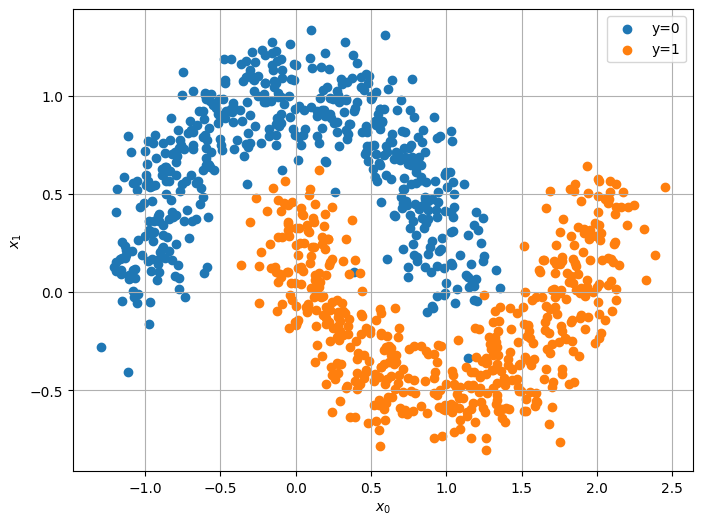

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0, 0], X[y == 0, 1], label='y=0')
plt.scatter(X[y == 1, 0], X[y == 1, 1], label='y=1')
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.legend()
plt.grid()

Обучите модели и визуализируйте разделяющую поверхность для обеих моделей с помощью функции plot_separating_surface(). Посчитайте точность (accuracy) на обучающей выборке для каждой из моделей.

In [11]:
# Your code here

linear_svc.fit(X, y)
nonlinear_svc.fit(X, y)
print(f'Train Accuracy (linear): {accuracy_score(y, linear_svc.predict(X)):.3f}')
print(f'Train Accuracy (non linear): {accuracy_score(y, nonlinear_svc.predict(X)):.3f}')

Train Accuracy (linear): 0.884
Train Accuracy (non linear): 0.994


**Сделайте вывод**
о получившихся результатах. Какая из моделей лучше подходит для данной выборки и почему? 

**Вывод:**

# 2. Опорные объекты (2 балла)

Продолжаем работать с выборкой и моделями из первой части. Для линейной и rbf-моделей рассмотрим 
    опорные объекты, полученные после обучения. Визуализировать их можно, используя функуцию plot_separating_surface с параметром vis_support=True. Достанем опорные объекты из обученной модели с помощью поля model.support_.

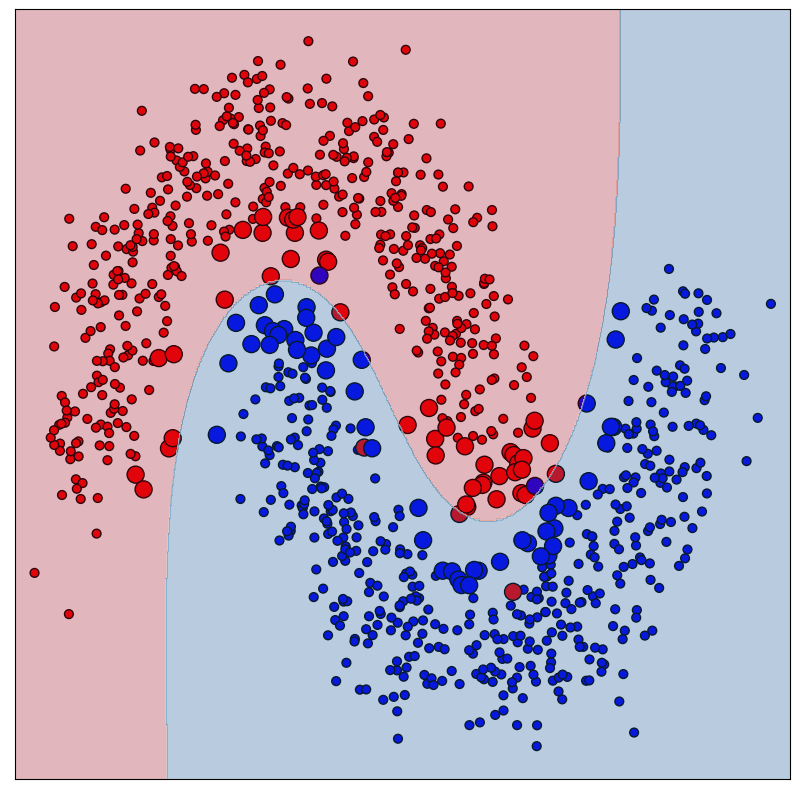

In [12]:
plot_separating_surface(X, y, nonlinear_svc, view_support=True)

**Пункт 1**
Обучим новые две модели $\mbox{SVC(kernel='rbf')}$, используя только опорные объекты построенные с помощью соответственно линейной (linear_svc) и нелинейной (nonlinear_svc) моделей из первой части.

In [13]:
# Учим модели только на опорных объектах
svc_on_linear_support = SVC(kernel='rbf').fit(X[linear_svc.support_, :], y[linear_svc.support_])
svc_on_rbf_support = SVC(kernel='rbf').fit(X[nonlinear_svc.support_, :], y[nonlinear_svc.support_])

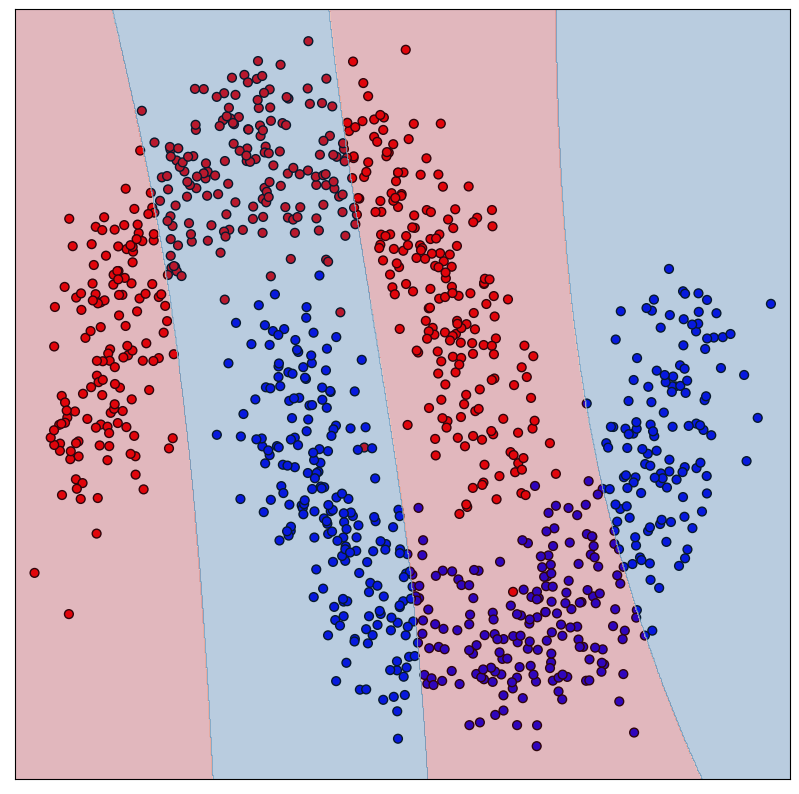

In [14]:
plot_separating_surface(X, y, svc_on_linear_support)

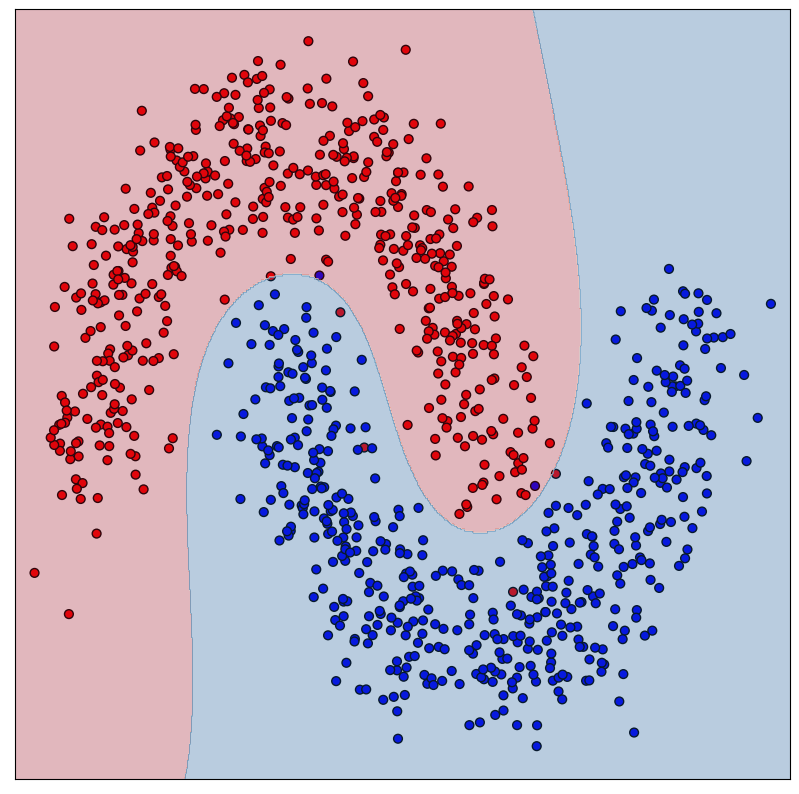

In [15]:
plot_separating_surface(X, y, svc_on_rbf_support)

**Задание:** Сравните полученные разделяющие поверхности с нелинейной моделью (nonlinear_svc) из первой части. Какая из поверхностей больше похожа на нелинейнную модель из первой части и почему, опишите в выводе. 

**Вывод:**

**Пункт 2** Обучим модель $\mbox{SVC(kernel='rbf')}$, используя все объекты кроме тех, что являлись опорными для нелинейной модели из первой части (nonlinear_svc) и сравним эту модель вместе с svc_on_rbf_support с нелинейной моделью из первой части (nonlinear_svc). Визуализируйте разделяющие поверхности обеих моделей.

In [16]:
non_support_vectors = [i for i in range(len(X)) if i not in nonlinear_svc.support_]
svc_all_without_rbf_support = SVC(kernel='rbf').fit(X[non_support_vectors, :], y[non_support_vectors])

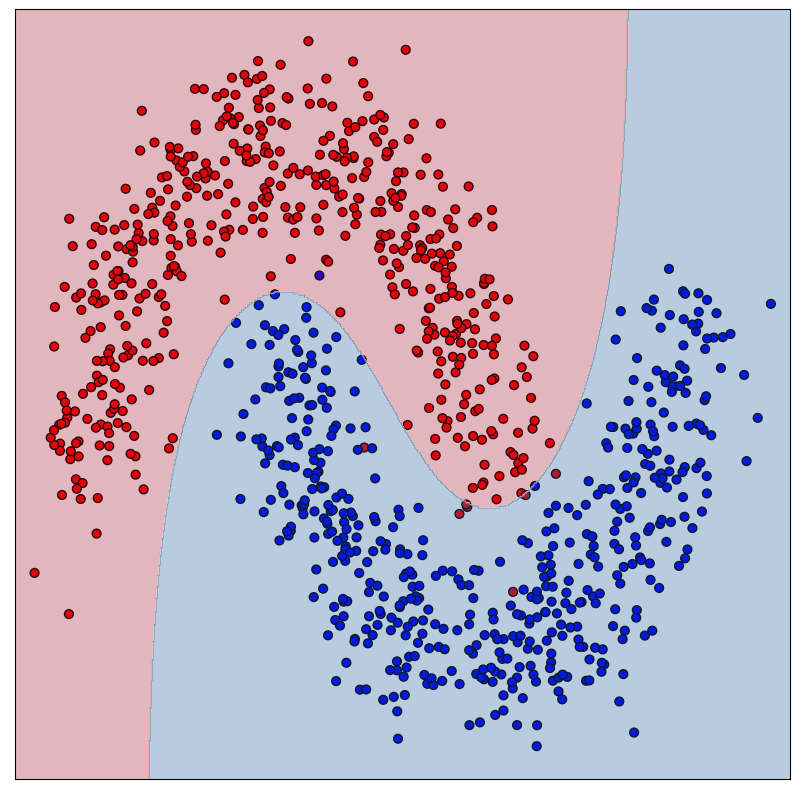

In [17]:
plot_separating_surface(X, y, svc_all_without_rbf_support)

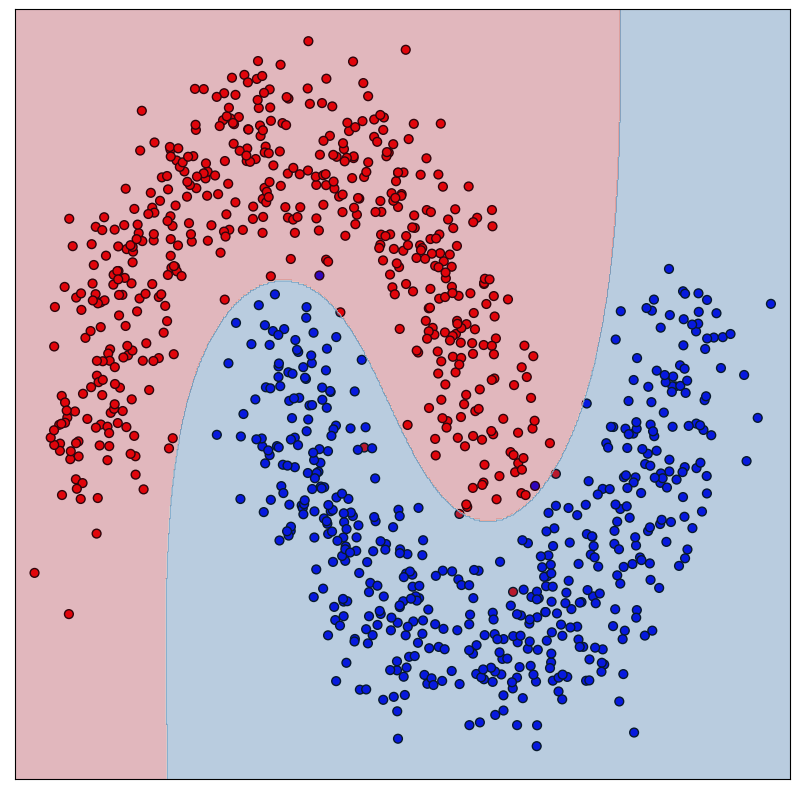

In [18]:
plot_separating_surface(X, y, nonlinear_svc)

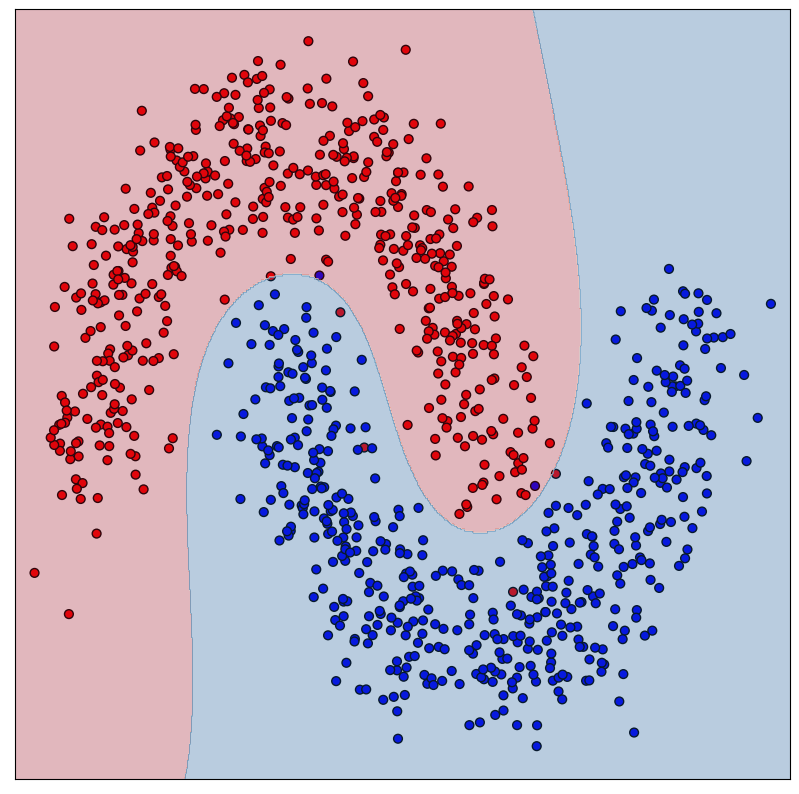

In [19]:
plot_separating_surface(X, y, svc_on_rbf_support)

**Сделайте вывод:** Сильно ли полученные поверхности отличаются от той, что была получена в первой части? Что произошло с пограничными объектами? Объясните полученные результаты.

**Вывод:**

# 3. Форма разделяющей поверхности для несбалансированных классов (3 балла)

Формы разделяющих поверхностей могут быть вариативными для нелинейного случая. Иногда, выбранная форма поверхности может плохо подходить для целевого распределения объектов. Особенно это может быть заметно, если соотношение  классов в обучении отличается от тестового. Такое свойственно медицинским данным, где в обучающих данных часто наблюдается перекос в сторону больных, так как именно их данные чаще собираются.

Давайте обучим SVC на несбалансированных данных и построим разделяющую поверхность для тестовой выборки с другим соотношением классов.

In [20]:
X_distr1 = np.load('05-SVM/imbalanced/X_imb.npz.npy')
y_distr1 = np.load('05-SVM/imbalanced/y_imb.npz.npy')
X_distr2 = np.load('05-SVM/imbalanced/X_imb_test.npz.npy')
y_distr2 = np.load('05-SVM/imbalanced/y_imb_test.npz.npy')

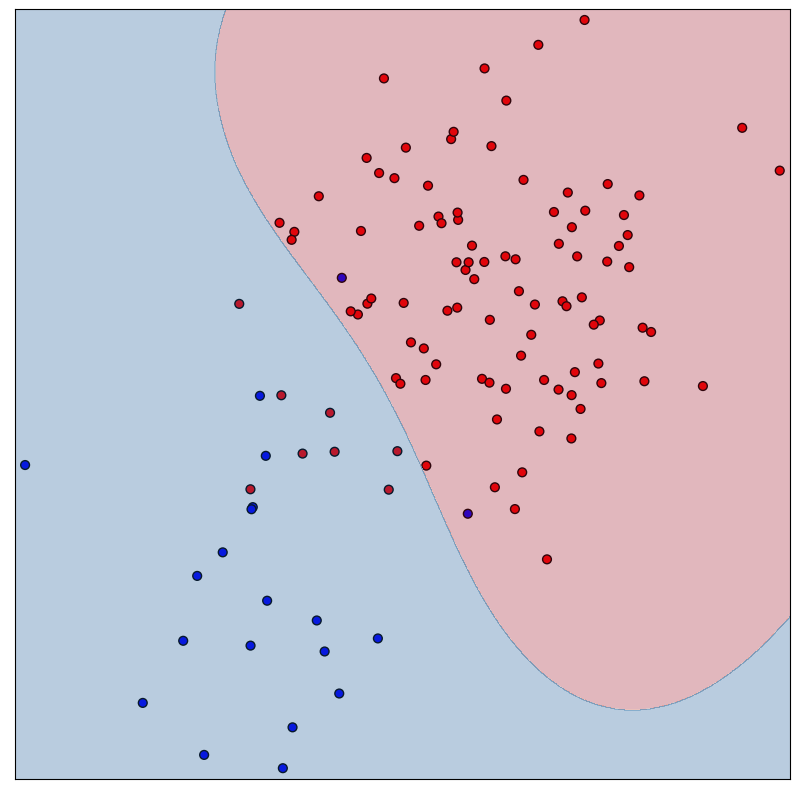

In [21]:
# Модель с дефолтными параметрами, которую Вам предстоит улучшить
base_model = SVC()
base_model.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, base_model)

Так как синих объектов было существенно больше в обучении, разделяющая поверхность отнесла к этому классу большую часть пространства около границы классов. При этом, из-за возросшего количества красных объектов в тестовой выборке, многие из них стали ошибочно относиться к другому классу.

Один из способов исправить эту проблему - это повлиять на форму поверхности с помощью задания весов классов, которые задаются через параметр class_weight в sklearn.svm.SVC. Особенно это может быть полезно в задачах, где известно, что распределение классов в обучающей выборке отличается от реального.
    
В данном задании вам будет дана выборка с несбалансированными данными. Кроме того, дана вторая выборка,
в которой классы имеют то же распределение, но классы имеют другое соотношение.  **Вам нужно построить различные rbf-модели, меняя параметры весов классов и визуализировать разделяющие поверхности. Попробуйте улучшить 
качество на второй выборке (X_distr2, y_distr2), обучаясь только на первой (X_distr1, y_distr1) меняя параметры весов классов относительно дефолтных: class_weight={1: 1.0, 0: 1.0}. В качестве метрики, которую нужно оптимизировать нужно использовать accuracy на (X_distr2, y_dist2).**

In [22]:
from itertools import product

In [23]:
w1_best, w2_best = None, None
best_acc = None
grid = [0.01, 0.1, 0.5, 1.0, 5, 10, 100, 1000]
for w1, w2 in product(grid, grid):
    svc_cls = SVC(C=1.0, class_weight={1: w1, 0: w2})
    svc_cls.fit(X_distr1, y_distr1)
    acc = accuracy_score(y_distr2, svc_cls.predict(X_distr2))
    # Save model with best accuracy
    # Your code here
            

print(f'Weight1: {w1_best},\nWeight2: {w2_best},\nBest accuracy: {best_acc}')

Weight1: None,
Weight2: None,
Best accuracy: None


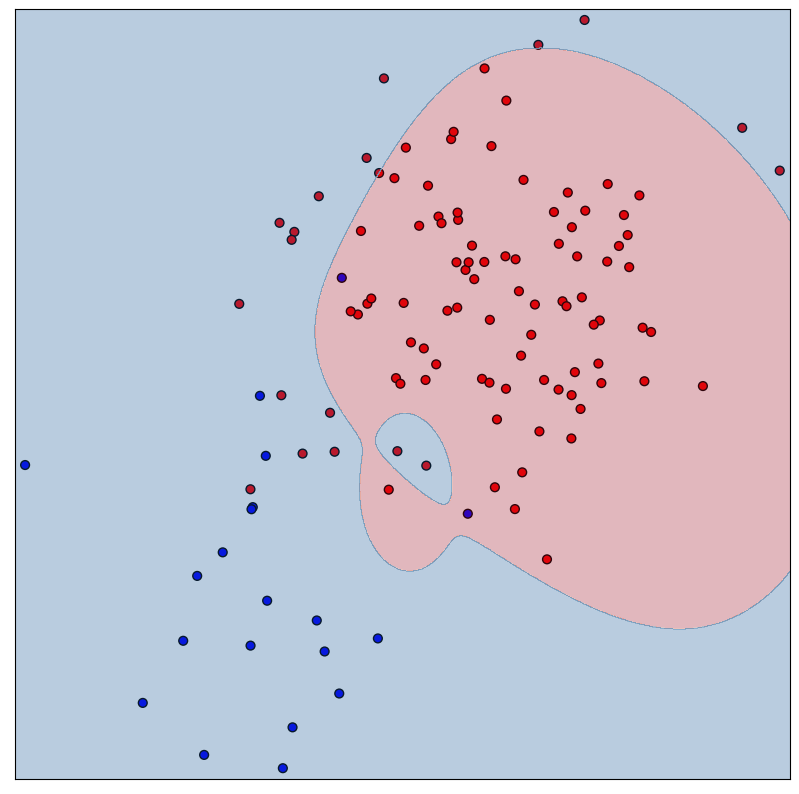

In [25]:
best_svc_cls = SVC(C=1.0, class_weight={1: w1_best, 0: w2_best})
best_svc_cls.fit(X_distr1, y_distr1)
plot_separating_surface(X_distr2, y_distr2, best_svc_cls)

In [26]:
print('My best classifier:')
print('Accuracy:', accuracy_score(y_distr2, best_svc_cls.predict(X_distr2)))

My best classifier:
Accuracy: 0.8333333333333334


# 4. Обучите лучшую SVM модель (ML-решение)

Возможность строить нелинейные поверхности может сильно улучшить качество, но и несет риск переобучения. 
    В этом задании предстоит обучить лучшую svm модель и получить хорошее качество на тесте в системе тестирования. Для контроля переобучения рекомендуется пользоваться кросс-валидацией. Для улучшения качества рекомендуется подбирать

1. параметр регуляризации C;
2. тип разделяющей кривой linear/rbf/poly;
3. степень в случае разделяющей кривой poly.

Также не забывайте, что при решении задач машинного обучения полезно смотреть в данные :) 

Все csv-таблицы с данными вы можете взять из публичного теста, который также есть в проверяющей системе. Для этого распакуйте архив с публичными тестами и положите файлы в рабочей директории (рядом с ноутбуком)

In [27]:
X_train = np.load('05-SVM/public/cX_train.npy')
y_train = np.load('05-SVM/public/cy_train.npy')
X_test = np.load('05-SVM/public/cX_test.npy')

In [28]:
X_train.shape, y_train.shape, X_test.shape

((800, 5), (800,), (200, 5))

In [29]:
X = X_train
y = y_train.ravel()

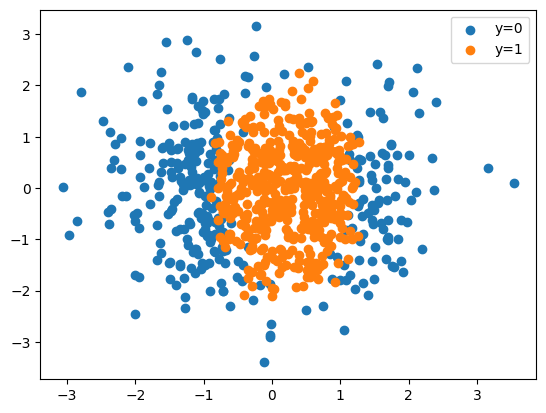

In [30]:
plt.scatter(X[y == 0, 4], X[y == 0, 3], label='y=0')
plt.scatter(X[y == 1, 4], X[y == 1, 3], label='y=1')
plt.legend()

**Отправьте код обучения модели с оптимальными параметрами в проверяющую систему, воспользовавшись приложенным шаблоном svm_solution.py. Кросс-валидацию параметров в посылаемом решении делать <font color='red'>не нужно</font> -- достаточно подобрать, например, их тут, а в решении уже обучать модель с оптимальными параметрами.**

# 4. Влияние гиперпараметров (4 балла)

В предыдущей части Вы обучили хорошую SVM модель, подбирая гиперпараметры модели. Давайте теперь попробуем обучить логистическую регрессию на этой же выборке, и по кросс-валидации оценить влияние гиперпараметров на линейную модель.

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
# Your code here

Сделайте выводы о влиянии выбора гиперпараметров на качество обучения линейной и SVC моделей. Также опишите, какие преобразования выборки/подбор каких гиперпараметров помогли добиться высокого качества на кросс-валидации в данной задаче.

**Вывод:**

# 5. Ограничения SVM (3 балла)

В предыдущих заданиях мы убедились в мощности и гибкости моделей SVM. Теперь ответим на вопрос, насколько реально обучить модель SVM на выборках большого размера или с большим числом признаков. 
    
   Нужно провести два эксперимента. В первом перебирать размер выборки
    и для каждого запуска посчитать реальное время обучения модели. При этом
    делить выборку на обучение и тестирование не нужно. Также качество обученной модели в данном эксперименте не имеет значение. Размеры выборки предлагается перебирать в диапазоне range(1000, 10001, 1000) с использованием generate_data_with_balanced_classes(size=n). 
    
   Необходимо сравнить время обучения SVM с логистической регрессией. Для этого
    замеры повторите также для модели sklearn.linear_model.LogisticRegression. Время обучения одной модели замеряйте 
    с помощью стандартной библиотеки time (пример в ячейке ниже). 
    
Вы можете поставить эксперименты и с большими выборками, чем предлагается в задании (сгенерировать их),  
тогда эффект должен быть виден еще сильнее.

**Внимание!** во время замеров времени работы, отключите сторонние процессы, занимающие CPU, иначе замеры времени работы окажутся некорректными. Помните, что времени работы в зависимости от числа данных и признаков должно меняться монотонно, без ступенчатых изменений (за исключением небольшого шума).

In [33]:
# Как замерять время
import time
time_start = time.time()
time.sleep(1) # Вместо этой команды - запуск замеряемого алгоритма
print("Время работы:", time.time() - time_start)

Время работы: 1.000432014465332


In [34]:
def generate_data_with_balanced_classes(size=500, d=2, noise_scale=0.1):
    X = np.random.normal(size=(size*2, d))
    mask = X[:, 1] ** 2 > X[:, 0] - 0.1 + np.random.normal(scale=noise_scale)
    y = np.ones(len(X))
    y[mask] = 0
    return X, y

In [35]:
# Your code here

Во втором эксперименте предлагается проделать то же самое, что и в первом эксперименте, только меняя размерность пространства признаков. 
    Для этого можете воспользоваться функцией generate_data_with_balanced_classes(dim=d). Признаки предлагается перебирать по сетке $range(10, 1001, 100)$. 

In [36]:
# Your code here

Постройте графики времени работы в зависимости от числа объектов для SVM и логистической регрессии, сравните их и сделайте выводы.
    
Придумывая обоснование получившимся результатам попробуйте использовать
    вид решаемой задачи в SVM, который был дан вам на лекции. 

**Вывод:**

# 6. Уменьшение размерности входа (4 балла)

Если уменьшение числа объектов сложная и зачастую невозможная задача, то
    для понижения числа признаков существует стандартное решение. В предыдущих заданиях Вы уже сталкивались с l1-регуляризацией, которая позволяла уменьшить число признаков в задаче линейной классификации/регрессии. Однако для большинства ML-алгоритмов такой способ уменьшения числа признаков неприменим.
    
   Зато существует стандартное для всех алгоритмов понижение размерности входа. Данный алгоритм называется Principal Component Analysis (PCA, метод главных компонент). Он находит такое линейное пространство меньшей размерности $k$ ($k << d$, где d изначальная размерность входа), проекция на которое теряет меньше всего информации. Подробнее об этом можете почитать тут https://scikit-learn.org/stable/modules/decomposition.html#pca. 
    
   **Эксперимент:** Проекция в очень малое число координат сильно "упрощает" выборку, из-за чего качество решения задачи может в итоге упасть. **В следующем эксперименте предлагается исследовать зависимость скорости работы метода и качества решения задачи при использовании понижения размерности. Требуется построить два графика:**

1. График зависимости времени работы всего цикла обучения от числа признаков $k$, которое остается после применения PCA. 
2. График зависимости качества решения (accuracy) задачи классификации от числа признаков $k$, которое остается после применения PCA.
    
При этом под полным циклом обучения подразумевается обучение PCA + обучение SVM. Данные для обучения: первые две координаты - луны, которые были в первом задании, а остальные координаты, случайные. 
Таким образом, без понижения размерности SVM с rbf ядром должен иметь точность близкую к 100\%. Чтобы лучше
видеть эффект на графиках, можете менять размер генерируемой выборки. Для данных размеров $k$ рекомендуется перебирать от 10 до 500 (тогда будет видна требуемая закономерность). 
    
   **P.S. Не забывайте делить выборку на обучение и валидацию в этом эксперименте** (так как мы смотрим на качество, мы хотим считать его честно). При этом PCA как и любой другой алгоритм ML тоже нельзя учить на тесте. Общая схема применения PCA описана в ячейках ниже. 

In [37]:
X_moons, y_moons = make_moons_cls(2000, 1000)

In [38]:
X_moons.shape

(2000, 1000)

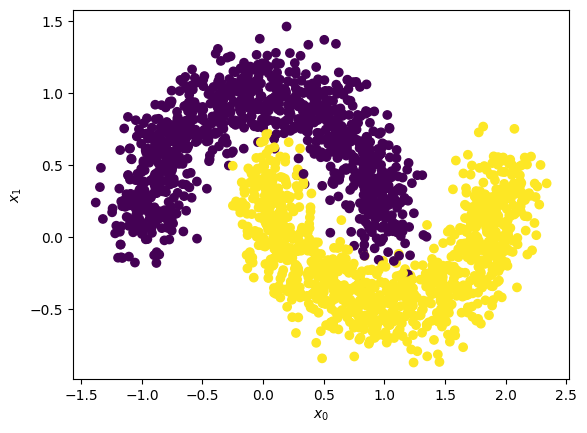

In [39]:
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.show()

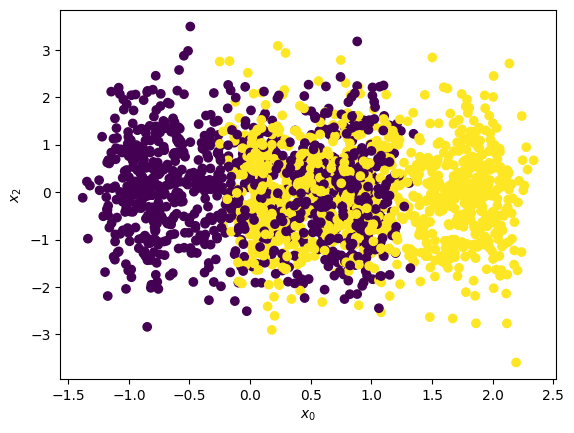

In [40]:
plt.scatter(X_moons[:, 0], X_moons[:, 2], c=y_moons)
plt.xlabel('$x_0$')
plt.ylabel('$x_2$')
plt.show()

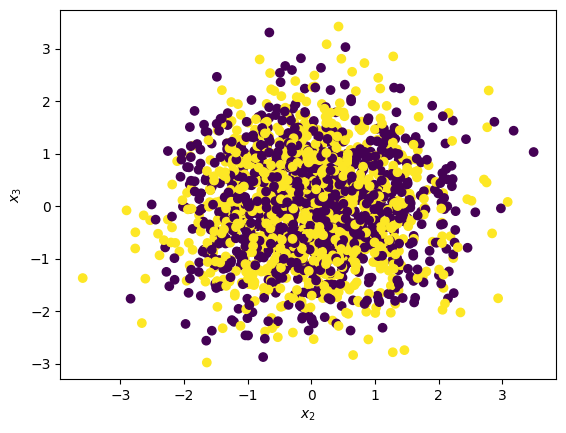

In [41]:
plt.scatter(X_moons[:, 2], X_moons[:, 3], c=y_moons)
plt.xlabel('$x_2$')
plt.ylabel('$x_3$')
plt.show()

Казалось бы понизить размерность в этой задаче достаточно легко, нужно просто выбрать только первые две координаты. Однако из-за нелинейности разделяющей поверхности, для PCA это задача нетривиальна. Такая же ситуация наблюдается и в большинстве прикладных задач. Теперь переходите **к эксперименту** :)

In [42]:
# Пример правильного обучения PCA с делением на train/test
pca_model = PCA(n_components=500)

X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.2) # делим выборку на трейн тест для оценки качества всего алгоритма

X_train_for_pca, X_train_for_svc, y_train_for_pca, y_train_for_svc = train_test_split(
    X_moons_train, y_moons_train, test_size=0.5) # делим выборку на трейн тест для оценки качества всего алгоритма

print(X_moons.shape, y_moons.shape)
print(X_moons_train.shape, y_moons_train.shape)
print(X_train_for_pca.shape, y_train_for_pca.shape)

# Учим PCA
pca_model.fit(X_train_for_pca)

# Применяем PCA
X_moons_test_transformed = pca_model.transform(X_moons_test)
X_train_for_svc_transformed = pca_model.transform(X_train_for_svc)

print(X_train_for_svc_transformed.shape)

# Учим SVC (на другой выборке чтобы не переобучиться)
svc_on_transformed = SVC(kernel='rbf')
svc_on_transformed.fit(X_train_for_svc_transformed, y_train_for_svc)

preds = svc_on_transformed.predict(X_moons_test_transformed)

print('Accuracy after PCA:', accuracy_score(preds, y_moons_test))

(2000, 1000) (2000,)
(1600, 1000) (1600,)
(800, 1000) (800,)
(800, 500)
Accuracy after PCA: 0.5975


In [43]:
# Your code here

Опишите в выводе как ведет себя качество решения задачи и время работы в зависимости от числа компонент в PCA.  

**Вывод:**

# 7. Калибровка вероятностей (3 балла)

Иногда в задаче классификации важно знать уверенность отнесения к тому или иному классу. В SVM за это отвечает параметр отступа (margin), который можно посчитать, используя model.decision_function(X). Именно отступ до разделяющей кривой пытается максимизироавть модель во время обучения. Однако по нему сложно утверждать с какой вероятностью объект относится к тому или иному классу.

Чтобы это понять давайте построим следующую кривую:
1) нормализуем отступы так, чтобы они лежали в диапазоне от 0 до 1;

2) разделим все объекты на бины по нормализованному оступу (например на [0, 0.1), [0.1, 0.2)...);

3) для каждого бина построим точку с координатой x - равной среднему значению нормализованного оступа внутри бина, и с координатой y - равной доле объектов класса 1 внутри бина.

Заметим теперь, что если бы нормализованный отступ приблизительно равнялся вероятности отнесения к классу, то бину [x, x + 0.1) должна была бы соответствовать точка с координатой Х принадлежащей [x, x + 0.1) и координатой Y в том же диапазоне. Таким образом, чем лучше скоры модели показывают вероятность отнесения к классу 1, тем больше калибровочная кривая похожа на прямую из точки (0, 0) в (1, 1).

Кроме того построим аналогично кривую для логистической регрессии, взяв вместо нормализованного отступа - вероятность отнесения к первому классу через predict_proba. Так как логистическая регрессия оптимизирует LogLoss и её выходом уже являются вероятности отнесения к классам, будем ожидать что её кривая хорошо ляжет на прямую из (0, 0) в (1, 1).

In [44]:
from sklearn.datasets import make_classification
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression

/home/ilyasavitsky/.local/share/virtualenvs/cmc-ml-course-hGB4l2-9/lib/python3.10/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(
/home/ilyasavitsky/.local/share/virtualenvs/cmc-ml-course-hGB4l2-9/lib/python3.10/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


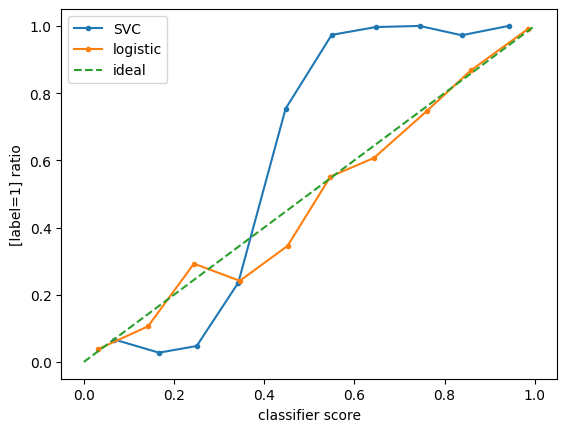

In [45]:

# generate 2 class dataset
X, y = make_classification(n_samples=5000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# fit a model
model = SVC()
model.fit(trainX, trainy)
# predict probabilities
probs = model.decision_function(testX)

# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
# plot model reliability
plt.plot(mpv, fop, marker='.', label='SVC')
plt.xlabel('classifier score')
plt.ylabel('[label=1] ratio')

logistic_model = LogisticRegression()
logistic_model.fit(trainX, trainy)

logistic_probs = logistic_model.predict_proba(testX)[:, 1]

# reliability diagram
log_fop, log_mpv = calibration_curve(testy, logistic_probs, n_bins=10, normalize=True)
# plot perfectly calibrated
# plot model reliability
plt.plot(log_mpv, log_fop, marker='.', label='logistic')
plt.plot([0, 1], [0, 1], linestyle='--', label='ideal')
plt.legend()
plt.show()

Вот мы и увидели проблему, линия отступов не ложится на пунктирную линию, что означает что оступы не соотвествуют реальным вероятностям отнесения к тому или иному классу.  

   Но не всё пропало! Из отступов всё ещё можно получить вероятность отнесения к классу. Для этого существует  такая процедура как калибровка вероятностей, при которой отступ для каждого объекта преобразовывается таким образом, чтобы соответствовать вероятности класса. После такого преобразования, полученное число становится интерпретируемой мерой уверенности модели. 

В данном задании Вам прелагается обучить логистическую регрессию на отступах модели, которая по оступу (margin) предсказывала бы класс. Именно вероятности этой калибровочной модели и будут нашими верными оценками вероятности класса для объекта:

$p(y_i | x_i) = p(y_i | margin_i)$

Для этого Вам потребуется написать несложный класс CalibratingLogisticRegression. И проверить что новые предсказания дают правильную калибровочную кривую

In [46]:
class CalibratingLogisticRegression:
    def fit(self, x, y):
        assert len(x.shape) == 1 or x.shape[1] == 1
        # Your code here
        
    def predict_proba(self, x):
        assert len(x.shape) == 1 or x.shape[1] == 1
        # Your code here

Калибровочную модель и исходную модель нельзя учить на одних и тех же данных, чтобы избежать переобучения. (распределение отступов на обучении и тестовой выборке, скорее всего очень сильно отличается)

In [47]:
model = SVC()
N = len(trainX) // 2
model.fit(trainX[:N], trainy[:N])

SVC()

In [48]:
margin = ...


# Учим калибровочную модель на второй половине данных
calibrating_model = CalibratingLogisticRegression()
calibrating_model.fit(margin, trainy[N:])
prob = calibrating_model.predict_proba(margin)


# Как это выглядит на обучении
margin_sorted, probs_sorted_by_margin = zip(*sorted(zip(margin, prob)))
plt.figure(figsize=(10, 10))
plt.plot(margin, trainy[N:], 'ro')
plt.plot(margin_sorted, probs_sorted_by_margin, 'b')
plt.show()

AttributeError: 'ellipsis' object has no attribute 'shape'

In [49]:
probs = calibrating_model.predict_proba(model.decision_function(testX))
# reliability diagram
fop, mpv = calibration_curve(testy, probs, n_bins=10, normalize=True)
# plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
plt.plot(mpv, fop, marker='.')
plt.show()

ValueError: y should be a 1d array, got an array of shape () instead.

Обратите внимание, что кривая для откалиброванных отступов должня также строиться для бинов и состоянть из n_bins точек. Если у Вас получилось кривая из трёх точек, Вы что-то сделали неправильно :)

**Сделайте выводы** о полученной модели. В каких задачах калибровка вероятностей могла бы быть полезной?

**Выводы:**

# Бонусное задание (2 балла)

Найдите мем про SVM лучше чем этот:

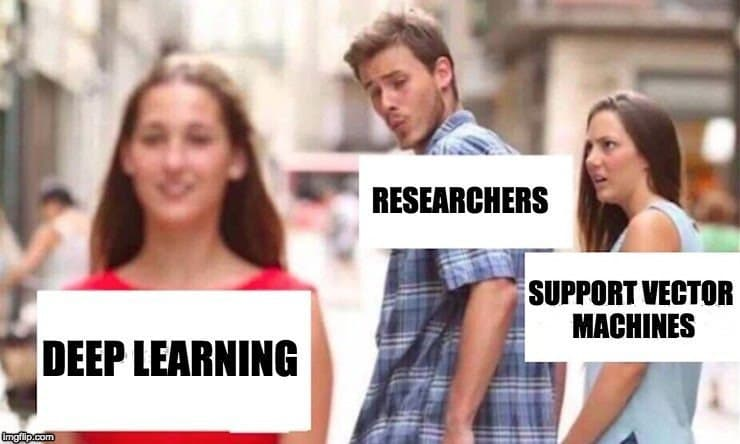

Важно: самый простой способ вставить картинку будет через Google Colab (даже если вы изначально делали не в нем). Нажмите на **"+ Text"**, в появившейся ячейке сделайте **прикрепление картинки** (как на скринах). Тогда ваша картинка "зашифруется" и будет корректно отображаться при конвертации в html

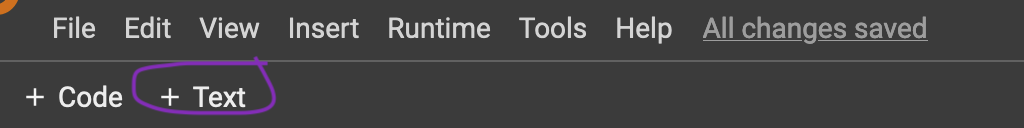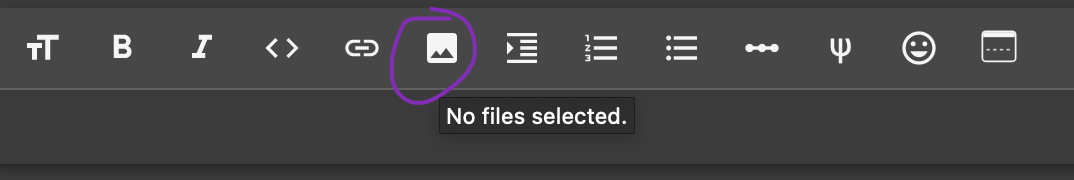